In [1]:
# !pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [2]:
# !nvidia-smi

In [3]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/gary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [5]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [6]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=2, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

### Load data

Link: https://huggingface.co/datasets/samsum

In [8]:
import pandas as pd
import os
from datasets import load_dataset

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['article'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['highlights'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }




# df2 = df[['article', 'highlights']]
data_dir  = "/home/gary/1.code/6.NLP_GPT2/dataset_nlp/text_summarization_cnn_dailynews"
train_file = "cnn_daily_news_1k_train.csv"
train_file = os.path.join(data_dir, train_file)
val_file = "cnn_daily_news_1k_val.csv"
val_file = os.path.join(data_dir, val_file)
# df2.iloc[:train_size].to_csv(os.path.join(data_dir, train_file))
# df2.iloc[train_size:].to_csv(os.path.join(data_dir, val_file))

# train_dataset = load_dataset("csv", data_files=train_file)
# val_dataset = load_dataset("csv", data_files=val_file)

data_files = {"train": train_file, "test": val_file}
ds = load_dataset("csv", data_files=data_files)


Found cached dataset csv (/home/gary/.cache/huggingface/datasets/csv/default-0e43165ae4e55093/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# dataset_samsum = load_dataset("samsum")

# split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

# print(f"Split lengths: {split_lengths}")
# print(f"Features: {dataset_samsum['train'].column_names}")
# print("\nDialogue:")

# print(dataset_samsum["test"][1]["dialogue"])

# print("\nSummary:")

# print(dataset_samsum["test"][1]["summary"])

# Evaluating PEGASUS on CNN daily news

In [10]:
ds['test'][0]['article']

'(CNN) -- A magazine photo spread of Taliban fighters posing in the uniforms of 10 French soldiers killed last month has sparked an angry response. One of the pictures in the French magazine Paris Match that has stirred controversy. The latest edition of Paris Match includes photos of the Taliban fighters and their commander, "Farouki," wearing French uniforms, helmets and using French assault rifles and walkie-talkies. Farouki, aged 30-35, claims in the accompanying story to have led his group in the August 18 ambush which killed 10 French troops and injured a further 21 in the Sarobi District, 40 miles east of Kabul. It was the French army\'s single highest death toll in 25 years. He said the area was "our territory" and the attack was a "legitimate" part of its defense. Farouki said it did not need a lot of planning, with the French soldiers only spotted a short time before the assault. He said the soldiers had died for "[George W.] Bush\'s" cause and that if France did not return t

In [11]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(ds['test'][0]['article'] )

print(pipe_out)

[{'summary_text': 'Photos of Taliban posing in the uniforms of dead French soldiers provokes outrage .<n>Magazine Paris Match features photos of Taliban and their commander .<n>10 French soldiers were killed and a further 21 injured in an ambush .'}]


In [12]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Photos of Taliban posing in the uniforms of dead French soldiers provokes outrage.
Magazine Paris Match features photos of Taliban and their commander.
10 French soldiers were killed and a further 21 injured in an ambush .


In [10]:
# rouge_metric = load_metric('rouge')

# score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)

In [11]:
# rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
# rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

# pd.DataFrame(rouge_dict, index = ['pegasus'])

# Histogram

In [21]:
# ds['train'].features.keys = ['Unnamed: 0', 'dialogue', 'summary']
# ds['test'].features.keys = ['Unnamed: 0', 'dialogue', 'summary']

In [23]:
ds['train'].features.keys()

dict_keys(['Unnamed: 0', 'article', 'highlights'])

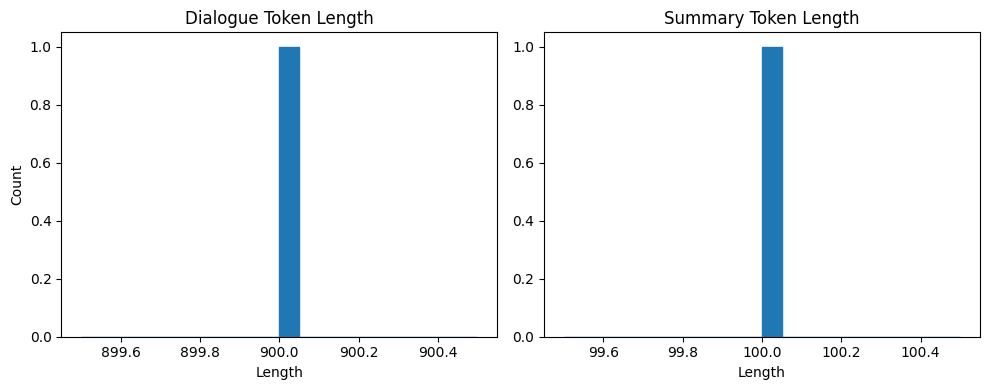

In [24]:
dialogue_token_len = len([tokenizer.encode(s) for s in ds['train']['article']])

summary_token_len = len([tokenizer.encode(s) for s in ds['test']['highlights']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [25]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['article'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['highlights'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
train_ds = ds['train'].map(convert_examples_to_features, batched = True)
test_ds = ds['test'].map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

/home/gary/anaconda3/envs/gpt2/lib/python3.8/site-packages/transformers-4.28.0.dev0-py3.8.egg/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [26]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
# %cd /content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM

In [27]:
from transformers import TrainingArguments, Trainer

model_dir  = "/home/gary/1.code/6.NLP_GPT2/model_save/pegasus_cnn"

# output_dir = os.path.join(data_dir, "")

trainer_args = TrainingArguments(
    output_dir=model_dir, num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=2,
    
    no_cuda=True,
) 
# fp16=True,

# optional parameters:
# output_dir, overwrite_output_dir, do_train, \
# do_eval, do_predict, evaluation_strategy, prediction_loss_only,\
# per_device_train_batch_size, per_device_eval_batch_size, \
# per_gpu_train_batch_size, per_gpu_eval_batch_size, \
# gradient_accumulation_steps, eval_accumulation_steps, \
# eval_delay, learning_rate, weight_decay, adam_beta1, \
# adam_beta2, adam_epsilon, max_grad_norm, num_train_epochs, \
# max_steps, lr_scheduler_type, warmup_ratio, warmup_steps, \
# log_level, log_level_replica, log_on_each_node, logging_dir, \
# logging_strategy, logging_first_step, logging_steps,\
# logging_nan_inf_filter, save_strategy, save_steps, \
# save_total_limit, save_safetensors, save_on_each_node, \
# no_cuda, use_mps_device, seed, data_seed, jit_mode_eval, \
# use_ipex, bf16, fp16, fp16_opt_level, half_precision_backend,\
# bf16_full_eval, fp16_full_eval, tf32, local_rank, xpu_backend,\
# tpu_num_cores, tpu_metrics_debug, debug, dataloader_drop_last,\
# eval_steps, dataloader_num_workers, past_index, run_name, \
# disable_tqdm, remove_unused_columns, label_names, \
# load_best_model_at_end, metric_for_best_model, \
# greater_is_better, ignore_data_skip, sharded_ddp,\
# fsdp, fsdp_min_num_params, fsdp_config, \
# fsdp_transformer_layer_cls_to_wrap, deepspeed, \
# label_smoothing_factor, optim, optim_args,\
# adafactor, group_by_length, length_column_name, \
# report_to, ddp_find_unused_parameters, ddp_bucket_cap_mb, \
# dataloader_pin_memory, skip_memory_metrics, use_legacy_prediction_loop,\
# push_to_hub, resume_from_checkpoint, hub_model_id, \
# hub_strategy, hub_token, hub_private_repo, gradient_checkpointing, \
# include_inputs_for_metrics, fp16_backend, push_to_hub_model_id, \
# push_to_hub_organization, push_to_hub_token, \
# mp_parameters, auto_find_batch_size, full_determinism,\
# torchdynamo, ray_scope, ddp_timeout, torch_compile, \
# torch_compile_backend, torch_compile_mode

In [29]:

trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=train_ds, 
                  eval_dataset=test_ds)

In [28]:
test_ds

Dataset({
    features: ['Unnamed: 0', 'article', 'highlights', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [30]:
trainer.train()


/home/gary/anaconda3/envs/gpt2/lib/python3.8/site-packages/transformers-4.28.0.dev0-py3.8.egg/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=450, training_loss=1.328407457139757, metrics={'train_runtime': 4734.9606, 'train_samples_per_second': 0.19, 'train_steps_per_second': 0.095, 'total_flos': 1733546026622976.0, 'train_loss': 1.328407457139757, 'epoch': 1.0})

In [ ]:
# from datasets import load_dataset
# def tokenize(batch):
#     tokenized_input = tokenizer(batch[text_column], padding=True, truncation=True, max_length=153)
#     tokenized_label = tokenizer(batch[generated_column], padding=True, truncation=True, max_length=274)

#     tokenized_input['labels'] = tokenized_label['input_ids']

#     return tokenized_input

# dataset = load_dataset('csv', data_files=dataset_file, split='train')
# dataset = dataset.train_test_split(test_size=0.05, seed=SEED)
# train_dataset = dataset['train']
# val_dataset = dataset['test']

# train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
# val_dataset = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
# train_dataset.set_format('numpy', columns=['input_ids', 'attention_mask', 'labels'])
# val_dataset.set_format('numpy', columns=['input_ids', 'attention_mask', 'labels'])
# # And then I use Trainer to train my T5 model like this:

# training_args = TrainingArguments(
# output_dir=output_dir,
# num_train_epochs=1,
# per_device_train_batch_size=8,
# per_device_eval_batch_size=8,
# eval_accumulation_steps=1,
# learning_rate=0.001,
# evaluation_strategy='steps',
# save_steps=1000000,
# save_total_limit=1,
# remove_unused_columns=True,
# run_name=now,
# logging_steps=100,
# eval_steps=100,
# logging_first_step=True
# )

# trainer = Trainer(
# model=model,
# args=training_args,
# train_dataset=train_dataset,
# eval_dataset=val_dataset
# )

# trainer.train()

In [ ]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

In [31]:
## Save model
model_dir  = "/home/gary/1.code/6.NLP_GPT2/model_save/pegasus_cnn"
model_name = "pegasus-cnn-model"
model_pegasus.save_pretrained(os.path.join(model_dir, model_name))

In [32]:
## Save tokenizer
tokenizer_name = "pegasus-cnn-model_tokenizer"
tokenizer.save_pretrained(os.path.join(model_dir, tokenizer_name))

('/home/gary/1.code/6.NLP_GPT2/model_save/pegasus_cnn/pegasus-cnn-model_tokenizer/tokenizer_config.json',
 '/home/gary/1.code/6.NLP_GPT2/model_save/pegasus_cnn/pegasus-cnn-model_tokenizer/special_tokens_map.json',
 '/home/gary/1.code/6.NLP_GPT2/model_save/pegasus_cnn/pegasus-cnn-model_tokenizer/spiece.model',
 '/home/gary/1.code/6.NLP_GPT2/model_save/pegasus_cnn/pegasus-cnn-model_tokenizer/added_tokens.json',
 '/home/gary/1.code/6.NLP_GPT2/model_save/pegasus_cnn/pegasus-cnn-model_tokenizer/tokenizer.json')

# Test

In [33]:
test_ds

Dataset({
    features: ['Unnamed: 0', 'article', 'highlights', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [36]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(model_dir, tokenizer_name))

In [34]:
sample_text = test_ds[0]["article"]

reference = test_ds[0]["highlights"]

In [35]:
reference

'Photos of Taliban in the uniforms of dead French soldiers provokes outrage .\nMagazine Paris Match features photos of Taliban and their commander .\n10 French troops were killed and a further 21 injured in an ambush .'

In [37]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model=os.path.join(model_dir, model_name),tokenizer=tokenizer)

In [38]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
(CNN) -- A magazine photo spread of Taliban fighters posing in the uniforms of 10 French soldiers killed last month has sparked an angry response. One of the pictures in the French magazine Paris Match that has stirred controversy. The latest edition of Paris Match includes photos of the Taliban fighters and their commander, "Farouki," wearing French uniforms, helmets and using French assault rifles and walkie-talkies. Farouki, aged 30-35, claims in the accompanying story to have led his group in the August 18 ambush which killed 10 French troops and injured a further 21 in the Sarobi District, 40 miles east of Kabul. It was the French army's single highest death toll in 25 years. He said the area was "our territory" and the attack was a "legitimate" part of its defense. Farouki said it did not need a lot of planning, with the French soldiers only spotted a short time before the assault. He said the soldiers had died for "[George W.] Bush's" cause and that if France did not r

In [39]:
sample_text = "The specific activity of enzymes can be altered over long timescales in cells by synonymous mutations that alter a messenger RNA molecule’s sequence but not the encoded protein’s primary structure. How this happens at the molecular level is unknown. Here, we use multiscale modelling of three Escherichia coli enzymes (type III chloramphenicol acetyltransferase, D-alanine–D-alanine ligase B and dihydrofolate reductase) to understand experimentally measured changes in specific activity due to synonymous mutations. The modelling involves coarse-grained simulations of protein synthesis and post-translational behaviour, all-atom simulations to test robustness and quantum mechanics/molecular mechanics calculations to characterize enzymatic function. We show that changes in codon translation rates induced by synonymous mutations cause shifts in co-translational and post-translational folding pathways that kinetically partition molecules into subpopulations that very slowly interconvert to the native, functional state. Structurally, these states resemble the native state, with localized misfolding near the active sites of the enzymes. These long-lived states exhibit reduced catalytic activity, as shown by their increased activation energies for the reactions they catalyse."
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
# print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
The specific activity of enzymes can be altered over long timescales in cells by synonymous mutations that alter a messenger RNA molecule’s sequence but not the encoded protein’s primary structure. How this happens at the molecular level is unknown. Here, we use multiscale modelling of three Escherichia coli enzymes (type III chloramphenicol acetyltransferase, D-alanine–D-alanine ligase B and dihydrofolate reductase) to understand experimentally measured changes in specific activity due to synonymous mutations. The modelling involves coarse-grained simulations of protein synthesis and post-translational behaviour, all-atom simulations to test robustness and quantum mechanics/molecular mechanics calculations to characterize enzymatic function. We show that changes in codon translation rates induced by synonymous mutations cause shifts in co-translational and post-translational folding pathways that kinetically partition molecules into subpopulations that very slowly interconve

In [40]:
sample_text =  '''
       Scientists say they have discovered a new species of orangutans on Indonesia’s island of Sumatra.
The population differs in several ways from the two existing orangutan species found in Sumatra and the neighboring island of Borneo.
The orangutans were found inside North Sumatra’s Batang Toru forest, the science publication Current Biology reported.
Researchers named the new species the Tapanuli orangutan. They say the animals are considered a new species because of genetic, skeletal and tooth differences.
Michael Kruetzen is a geneticist with the University of Zurich who has studied the orangutans for several years. He said he was excited to be part of the unusual discovery of a new great ape in the present day. He noted that most great apes are currently considered endangered or severely endangered.
Gorillas, chimpanzees and bonobos also belong to the great ape species.
Orangutan – which means person of the forest in the Indonesian and Malay languages - is the world’s biggest tree-living mammal. The orange-haired animals can move easily among the trees because their arms are longer than their legs. They live more lonely lives than other great apes, spending a lot of time sleeping and eating fruit in the forest.
The new study said fewer than 800 of the newly-described orangutans exist. Their low numbers make the group the most endangered of all the great ape species.
They live within an area covering about 1,000 square kilometers. The population is considered highly vulnerable. That is because the environment which they depend on is greatly threatened by development.
Researchers say if steps are not taken quickly to reduce the current and future threats, the new species could become extinct “within our lifetime.”
Research into the new species began in 2013, when an orangutan protection group in Sumatra found an injured orangutan in an area far away from the other species. The adult male orangutan had been beaten by local villagers and died of his injuries. The complete skull was examined by researchers.
Among the physical differences of the new species are a notably smaller head and frizzier hair. The Tapanuli orangutans also have a different diet and are found only in higher forest areas.
There is no unified international system for recognizing new species. But to be considered, discovery claims at least require publication in a major scientific publication.
Russell Mittermeier is head of the primate specialist group at the International Union for the Conservation of Nature. He called the finding a “remarkable discovery.” He said it puts responsibility on the Indonesian government to help the species survive.
Matthew Nowak is one of the writers of the study. He told the Associated Press that there are three groups of the Tapanuli orangutans that are separated by non-protected land.He said forest land needs to connect the separated groups.
In addition, the writers of the study are recommending that plans for a hydropower center in the area be stopped by the government.
It also recommended that remaining forest in the Sumatran area where the orangutans live be protected.
I’m Bryan Lynn.

        '''

print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
# print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:

       Scientists say they have discovered a new species of orangutans on Indonesia’s island of Sumatra.
The population differs in several ways from the two existing orangutan species found in Sumatra and the neighboring island of Borneo.
The orangutans were found inside North Sumatra’s Batang Toru forest, the science publication Current Biology reported.
Researchers named the new species the Tapanuli orangutan. They say the animals are considered a new species because of genetic, skeletal and tooth differences.
Michael Kruetzen is a geneticist with the University of Zurich who has studied the orangutans for several years. He said he was excited to be part of the unusual discovery of a new great ape in the present day. He noted that most great apes are currently considered endangered or severely endangered.
Gorillas, chimpanzees and bonobos also belong to the great ape species.
Orangutan – which means person of the forest in the Indonesian and Malay languages - is the world’